In [1]:
#import chainlit as cl
import os, getpass
env_path = r'C:\Users\VR679RX\OneDrive - EY\Documents\Projects\Projects - 2024\LangGraph_Academy\gpt4o.env'
from dotenv import load_dotenv
import json
from langchain_openai import AzureOpenAIEmbeddings, AzureChatOpenAI
load_dotenv(env_path)
from datetime import datetime
from langchain_core.pydantic_v1 import constr, BaseModel, Field, validator
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage
from langchain_core.prompts.chat import ChatPromptTemplate,MessagesPlaceholder
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import StructuredTool
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from langchain_core.runnables import Runnable, RunnableConfig
from langchain_community.tools import TavilySearchResults
import os
from langgraph.prebuilt import create_react_agent
from typing import  Literal
from langchain_core.tools import tool
from langchain.agents.openai_tools.base import create_openai_tools_agent
from langchain.agents.agent import AgentExecutor
import shutil
import sqlite3
import functools
import pandas as pd
import requests

c:\Users\VR679RX\OneDrive - EY\Documents\Projects\Projects - 2024\LangGraph_Academy\langgraph\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\VR679RX\OneDrive - EY\Documents\Projects\Projects - 2024\LangGraph_Academy\langgraph\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The l

In [2]:
llm = AzureChatOpenAI(temperature=0,
                           api_key=os.getenv('AZURE_OPENAI_API_KEY'),
                           azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
                           openai_api_version=os.getenv('AZURE_OPENAI_VERSION'),
                           azure_deployment=os.getenv('AZURE_GPT4O_MODEL')
                           )

embeddings = AzureOpenAIEmbeddings(
                            api_key=os.getenv('AZURE_OPENAI_API_KEY'),
                            azure_endpoint=os.getenv('AZURE_OPENAI_ENDPOINT'),
                            azure_deployment=os.getenv('AZURE_OPENAI_EMBEDDINGS_MODEL'),
                            openai_api_version=os.getenv('AZURE_OPENAI_VERSION'),
                            )

In [3]:

from langchain_core.pydantic_v1 import constr, BaseModel, Field, validator
import re


class DateTimeModel(BaseModel):
    """
    The way the date should be structured and formatted
    """
    date: str = Field(..., description="Propertly formatted date", pattern=r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$')

    @validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{4}-\d{2}-\d{2} \d{2}:\d{2}$', v):
            raise ValueError("The date should be in format 'YYYY-MM-DD HH:MM'")
        return v
    
class DateModel(BaseModel):
    """
    The way the date should be structured and formatted
    """
    date: str = Field(..., description="Propertly formatted date", pattern=r'^\d{2}-\d{2}-\d{4}$')

    @validator("date")
    def check_format_date(cls, v):
        if not re.match(r'^\d{2}-\d{2}-\d{4}$', v):
            raise ValueError("The date must be in the format 'YYYY-MM-DD'")
        return v

    
class IdentificationNumberModel(BaseModel):
    """
    The way the ID should be structured and formatted
    """
    id: int = Field(..., description="identification number without dots", pattern=r'^\d{7,8}$')

    @validator("id")
    def check_format_id(cls, v):
        if not re.match(r'^\d{7,8}$',str(v)):
            raise ValueError("The ID number should be a number of 7 or 8 numbers")
        return v

In [4]:
@tool
def check_availability_by_doctor(desired_date:DateModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Checking the database if we have availability for the specific doctor.
    The parameters should be mentioned by the user in the query
    """
    #Dummy data
    df = pd.read_csv(f"availability.csv")
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    rows = list(df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date)&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]['date_slot_time'])

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        output = f'This availability for {desired_date.date}\n'
        output += "Available slots: " + ', '.join(rows)

    return output

@tool
def check_availability_by_specialization(desired_date:DateModel, specialization:Literal["general_dentist", "cosmetic_dentist", "prosthodontist", "pediatric_dentist","emergency_dentist","oral_surgeon","orthodontist"]):
    """
    Checking the database if we have availability for the specific specialization.
    The parameters should be mentioned by the user in the query
    """
    #Dummy data
    df = pd.read_csv(f"availability.csv")
    df['date_slot_time'] = df['date_slot'].apply(lambda input: input.split(' ')[-1])
    rows = df[(df['date_slot'].apply(lambda input: input.split(' ')[0]) == desired_date.date) & (df['specialization'] == specialization) & (df['is_available'] == True)].groupby(['specialization', 'doctor_name'])['date_slot_time'].apply(list).reset_index(name='available_slots')

    if len(rows) == 0:
        output = "No availability in the entire day"
    else:
        def convert_to_am_pm(time_str):
            # Split the time string into hours and minutes
            time_str = str(time_str)
            hours, minutes = map(int, time_str.split("."))
            
            # Determine AM or PM
            period = "AM" if hours < 12 else "PM"
            
            # Convert hours to 12-hour format
            hours = hours % 12 or 12
            
            # Format the output
            return f"{hours}:{minutes:02d} {period}"
        output = f'This availability for {desired_date.date}\n'
        for row in rows.values:
            output += row[1] + ". Available slots: \n" + ', \n'.join([convert_to_am_pm(value)for value in row[2]])+'\n'

    return output

In [194]:
@tool
def reschedule_appointment(old_date:DateTimeModel, new_date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Rescheduling an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    #Dummy data
    df = pd.read_csv(f'availability.csv')
    available_for_desired_date = df[(df['date_slot'] == new_date.date)&(df['is_available'] == True)&(df['doctor_name'] == doctor_name)]
    if len(available_for_desired_date) == 0:
        return "Not available slots in the desired period"
    else:
        cancel_appointment.invoke({'date':old_date, 'id_number':id_number, 'doctor_name':doctor_name})
        set_appointment.invoke({'desired_date':new_date, 'id_number': id_number, 'doctor_name': doctor_name})
        return "Succesfully rescheduled for the desired time"

@tool
def cancel_appointment(date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Canceling an appointment.
    The parameters MUST be mentioned by the user in the query.
    """
    df = pd.read_csv(f'availability.csv')
    case_to_remove = df[(df['date_slot'] == date.date)&(df['patient_to_attend'] == id_number.id)&(df['doctor_name'] == doctor_name)]
    if len(case_to_remove) == 0:
        return "You don´t have any appointment with that specifications"
    else:
        df.loc[(df['date_slot'] == date.date) & (df['patient_to_attend'] == id_number.id) & (df['doctor_name'] == doctor_name), ['is_available', 'patient_to_attend']] = [True, None]
        df.to_csv(f'availability.csv', index = False)

        return "Succesfully cancelled"
    

@tool
def set_appointment(desired_date:DateTimeModel, id_number:IdentificationNumberModel, doctor_name:Literal['kevin anderson','robert martinez','susan davis','daniel miller','sarah wilson','michael green','lisa brown','jane smith','emily johnson','john doe']):
    """
    Set appointment or slot with the doctor.
    The parameters MUST be mentioned by the user in the query.
    """
    df = pd.read_csv(f'availability.csv')
    from datetime import datetime


    def convert_datetime_format(dt_str):
        # Parse the input datetime string
        dt = datetime.strptime(dt_str, "%Y-%m-%d %H:%M")
        
        # Format the output as 'DD-MM-YYYY H.M' (removing leading zero from hour only)
        return dt.strftime("%d-%m-%Y %#H.%M")
    
    case = df[(df['date_slot'] == convert_datetime_format(desired_date.date))&(df['doctor_name'] == doctor_name)&(df['is_available'] == True)]
    if len(case) == 0:
        return "No available appointments for that particular case"
    else:
        df.loc[(df['date_slot'] == convert_datetime_format(desired_date.date))&(df['doctor_name'] == doctor_name) & (df['is_available'] == True), ['is_available','patient_to_attend']] = [False, id_number.id]
        df.to_csv(f'availability.csv', index = False)

        return "Succesfully done"

In [6]:
from typing import Literal
from typing_extensions import TypedDict, Annotated
from langgraph.graph import MessagesState, END
from langgraph.types import Command
from langgraph.checkpoint.memory import MemorySaver

In [146]:
def create_agent(llm:AzureChatOpenAI,tools:list,system_prompt:str):
    system_prompt = ChatPromptTemplate.from_messages(
            [
                (
                    "system",
                    system_prompt
                ),
                ("placeholder", "{messages}"),
            ]
        )
    agent = create_react_agent(model=llm,tools=tools,prompt=system_prompt)
    return agent


In [152]:
class AgentState(MessagesState):
    id_number:IdentificationNumberModel
    query:str
    next:str
    cur_reasoning:str

In [153]:
information_agent = create_agent(
                        llm=llm,
                        tools=[check_availability_by_doctor,check_availability_by_specialization],
                        system_prompt = "You are specialized agent to provide information related to availbility of doctors or any FAQs related to hospital based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information, Always consider current year is 2024."
                )

booking_agent = create_agent(
                        llm=llm,
                        tools=[set_appointment,cancel_appointment,reschedule_appointment],
                        system_prompt = "You are specialized agent to set, cancel or reschedule appointment based on the query. You have access to the tool.\n Make sure to ask user politely if you need any further information to execute the tool.\n For your information, Always consider current year is 2024."
                )


In [154]:
def information_node(state: AgentState):
    result = information_agent.invoke(state)
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="information_node")
            ]
        },
        goto="supervisor",
    )

def booking_node(state: AgentState):
    result = booking_agent.invoke(state)
    return Command(
        update={
            "messages": state["messages"] + [
                AIMessage(content=result["messages"][-1].content, name="booking_node")
            ]
        },
        goto="supervisor",
    )


In [155]:
members_dict = {'information_node':'specialized agent to provide information related to availbility of doctors or any FAQs related to hospital.','booking_node':'specialized agent to only to book, cancel or reschedule appointment'}
options = list(members_dict.keys()) + ["FINISH"]
worker_info = '\n\n'.join([f'WORKER: {member} \nDESCRIPTION: {description}' for member, description in members_dict.items()]) + '\n\nWORKER: FINISH \nDESCRIPTION: If User Query is answered and route to Finished'

In [156]:
options

['information_node', 'booking_node', 'FINISH']

In [157]:
system_prompt = (
    "You are a supervisor tasked with managing a conversation between following workers. "
    "### SPECIALIZED ASSISTANT:\n"
    f"{worker_info}\n\n"
    "Your primary role is to help the user make an appointment with the doctor and provide updates on FAQs and doctor's availability. "
    "If a customer requests to know the availability of a doctor or to book, reschedule, or cancel an appointment, "
    "delegate the task to the appropriate specialized workers. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
    "UTILIZE last conversation to assess if the conversation should end you answered the query, then route to FINISH "
     )



In [158]:
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH. and provide reasoning for the routing"""

    next: Annotated[Literal[*options], ..., "worker to route to next, route to FINISH"]
    reasoning: Annotated[str, ..., "Support proper reasoning for routing to the worker"]

In [159]:
def supervisor_node(state: AgentState) -> Command[Literal[*list(members_dict.keys()), "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
        #{"role": "user", "content": f"user's identification number is {state['id_number']}"},
    ] + [state["messages"][-1]]
    query = ''
    if len(state['messages'])==1:
        query = state['messages'][0].content
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = END
    if query:
        return Command(goto=goto, update={"next": goto,'query':query,'cur_reasoning':response["reasoning"],
                                    "messages":[HumanMessage(content=f"user's identification number is {state['id_number']}")]
                        })
    return Command(goto=goto, update={"next": goto,'cur_reasoning':response["reasoning"]})

In [160]:
builder = StateGraph(AgentState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("information_node", information_node)
builder.add_node("booking_node", booking_node)
graph = builder.compile()

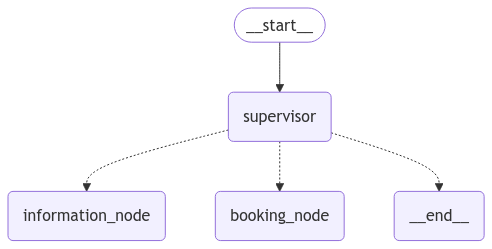

In [161]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [199]:
inputs = [
        HumanMessage(content='can you reschedule my appointment with Jane smith at 8 August 2024 at 9 AM to 9 Auguest at same time?')
    ]

config = {"configurable": {"thread_id": "1", "recursion_limit": 10}}  

state = {'messages': inputs,'id_number':10232303}

In [200]:
result = graph.invoke(input=state,config=config)

In [197]:
# events = []
# async for event in graph.astream_events(input=state, config=config,version="v1"):
#     print(event)
#     events.append(event)

In [201]:
result

{'messages': [HumanMessage(content='can you reschedule my appointment with Jane smith at 8 August 2024 at 9 AM to 9 Auguest at same time?', additional_kwargs={}, response_metadata={}, id='482ef00b-f4a5-43fa-8dd4-6dde4041648f'),
  HumanMessage(content="user's identification number is 10232303", additional_kwargs={}, response_metadata={}, id='acc6a469-664d-48d2-b60d-e782737f75b6'),
  AIMessage(content='It appears that there are no available slots for Dr. Jane Smith on August 9, 2024, at 9:00 AM.\n\nWould you like to choose a different date or time for the rescheduling?', additional_kwargs={}, response_metadata={}, name='booking_node', id='0886dcbe-1922-4cca-a588-3f6b2a13d4a1'),
  AIMessage(content='I can help you with that. To confirm, you would like to reschedule your appointment with Dr. Jane Smith from August 8, 2024, at 9:00 AM to August 9, 2024, at the same time. Is that correct?', additional_kwargs={}, response_metadata={}, name='booking_node', id='ffaf3abb-4293-4a57-9fd0-3b612b47c

In [193]:
for event in events:
    if event['event']=='on_chain_end' and event['name'] in ['supervisor']+options:
        #print(event)
        print(event['name'])
        print(event['data']['input']['messages'][-1].content)
        print('-------')

supervisor
can you check and make a booking if any cosmetic dentist available on 8 August 2024 at 9 AM?
-------
information_node
user's identification number is 10232303
-------
supervisor
Both Dr. Jane Smith and Dr. Lisa Brown, who are cosmetic dentists, have availability on 8th August 2024. Specifically, Dr. Jane Smith is available at 9:00 AM.

Would you like to proceed with booking an appointment with Dr. Jane Smith at 9:00 AM?
-------
booking_node
Both Dr. Jane Smith and Dr. Lisa Brown, who are cosmetic dentists, have availability on 8th August 2024. Specifically, Dr. Jane Smith is available at 9:00 AM.

Would you like to proceed with booking an appointment with Dr. Jane Smith at 9:00 AM?
-------
supervisor
Your appointment with Dr. Jane Smith has been successfully booked for 8th August 2024 at 9:00 AM.
-------


In [207]:
event_dict = {}
event_result = ''
for event in events:
    if event['event']=='on_chain_end' and event['name'] in ['supervisor'] + options:
        print(event['name'])
        event_dict[event['run_id']] = event['name']
        event_result = event['data']['input']['messages'][-1].content
        #print(event['data']['input']['messages'][-1].content)
        print('-------')

supervisor
-------
information_node
-------
supervisor
-------
booking_node
-------
supervisor
-------


In [208]:
event_result

'Your appointment with Dr. Jane Smith has been successfully booked for 8th August 2024 at 9:00 AM.'